In [7]:
import sympy as sp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import autoscattering.architecture_optimizer as arch_opt
import autoscattering.constraints as msc
import autoscattering.symbolic as sym

from autoscattering.architecture import adjacency_to_triu_matrix, triu_to_adjacency_matrix



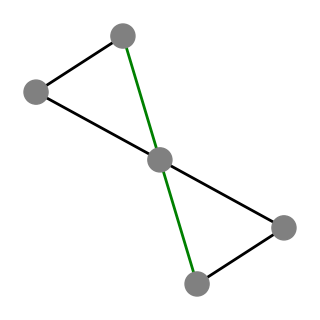

In [5]:
triu_matrix = [0,0,1,0,1,0,1,1,0,0,2,2,0,0,0]
upper_triu_adjacency_matrix = triu_to_adjacency_matrix(triu_matrix)
plt.figure(figsize=(3,3))
msc.plot_graph(triu_matrix=triu_matrix, node_colors=['gray']*5)

In [93]:
def find_min_number_of_pumps(triu_matrix):
    '''
    Identifies the minimum number of parametric pumps required to realise this graph
    To do so, we label all modes. If two modes have the same label, they are operated at the same frequency, otherwise they are not.
    To find the minimum number of pumps we iterate over all possible labeling combinations. 
    This function is doing this quite inefficiently doing this and has a lot of redundancies. To do in future: Remove the redundancies!
    Current runtime: ~50ms per graph if the graph has 5 modes
    '''
    
    upper_triu_adjacency_matrix = triu_to_upper_triu_adjacency_matrix(triu_matrix)
    num_modes = upper_triu_adjacency_matrix.shape[0]
    
    counted_pumps = []
    possible_labels = np.arange(num_modes)
    for labels in product(*([possible_labels]*num_modes)):
        result = count_pumps(labels, upper_triu_adjacency_matrix=upper_triu_adjacency_matrix)
        if result is not None:
            counted_pumps.append(result)

    return np.min(counted_pumps)

def triu_to_upper_triu_adjacency_matrix(triu_matrix):
    '''
    transform a graph in list form to its adjacency matrix, where the lower triangle is set to zero
    the full adjacency matrix would be provided by the function triu_to_adjacency_matrix
    '''
    size_upper_triangle_matrix = len(triu_matrix)
    num_modes = int((-1 + np.sqrt(1+4*2*size_upper_triangle_matrix))//2)
    idxs_upper_triangle = np.array(np.triu_indices(num_modes))
    adjacency_matrix = np.zeros([num_modes, num_modes], dtype='int8')
    for idxs, value in zip(idxs_upper_triangle.T, triu_matrix):
        adjacency_matrix[idxs[0], idxs[1]] = value
    return adjacency_matrix

def count_pumps(labels, triu_matrix=None, upper_triu_adjacency_matrix=None):
    '''
    Counts the number of parametric pumps given a certain graph and labels

    labels: list of integers equalling the number of modes. If two modes have the same label (the same integer), the are operated at the same frequency. Modes with different labels are operated at different frequencies
    triu_matrix: defines the graph as a list containing the elements of the upper triangular matrix of the adjacency matrix
    upper_triu_adjacency_matrix: adjacency matrix, where the lower triangle is set to zero. Passing an actual adjacency matrix will result in a miscounting!

    If both triu_matrix and upper_triu_adjacency_matrix are passed, the function will use triu_matrix
    '''
    if triu_matrix is not None:
        upper_triu_adjacency_matrix = triu_to_upper_triu_adjacency_matrix(triu_matrix)

    # if a coupling is either a complex-valued beamsplitter interaction or a squeezing interaction the labels have to be different between the modes connected by the correspond edge
    # this loop tests if this is the case, if not the function returns None as the labeling is not valid
    idxs1, idxs2 = np.where(upper_triu_adjacency_matrix==2)
    for idx1, idx2 in zip(idxs1, idxs2):
        if labels[idx1] == labels[idx2]:
            return None
    
    # Now we count the pumps. We sum over all edges. If an edge connects two modes with a different label, a pump is required, otherwise not.
    num_pumps = 0
    idxs1, idxs2 = np.where(upper_triu_adjacency_matrix!=0)
    for idx1, idx2 in zip(idxs1, idxs2):
        if labels[idx1] != labels[idx2]:
            num_pumps += 1

    return num_pumps

In [94]:
idxs1, idxs2 = np.where(triu_to_upper_triu_adjacency_matrix(triu_matrix)==2)

In [95]:
%%timeit
count_pumps(triu_matrix, [1,1,1,2,2])

81.5 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [99]:
# %%timeit
find_min_number_of_pumps([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0])

3